## Tasks
 - Location of houses per 10-20 years

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
import plotly.express as px
pd.options.display.float_format = '{:.2f}'.format
warnings.simplefilter(action='ignore')
sn.set()

### Load the data

In [7]:
data = pd.read_csv('housing_data.csv')

In [8]:
#Choosing some columns to show later
feats = ["sold_price","zipcode","lot_acres","year_built","bedrooms","bathrooms","garage","fireplaces"]

### Check type variables and quick observations
    -There are missing values
    -Cast sold_price, fireplaces to int
    -There are features which should be numerical type like sqrt_ft and garage, however it shows an "object" type
    -Check bathrooms feature which is float, it may indicate half bathrooms (without shower)
    -Fireplaces features should be whole numbers (int), but its Dtype shows decimal (float64)
    -Check "None" values. They may indicate either an absence or information (like NaN) or 0

### General database information

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MLS               5000 non-null   int64  
 1   sold_price        5000 non-null   float64
 2   zipcode           5000 non-null   int64  
 3   longitude         5000 non-null   float64
 4   latitude          5000 non-null   float64
 5   lot_acres         4990 non-null   float64
 6   taxes             5000 non-null   float64
 7   year_built        5000 non-null   int64  
 8   bedrooms          5000 non-null   int64  
 9   bathrooms         5000 non-null   object 
 10  sqrt_ft           5000 non-null   object 
 11  garage            5000 non-null   object 
 12  kitchen_features  5000 non-null   object 
 13  fireplaces        4975 non-null   float64
 14  floor_covering    5000 non-null   object 
 15  HOA               5000 non-null   object 
dtypes: float64(6), int64(4), object(6)
memory 

### Extracting features and classify

In [10]:
cols = [var for var in data.columns if var != "MLS"]
num_cols = [var for var in cols if data[var].dtype != 'O' and var != 'year_built']
cat_cols = [var for var in cols if data[var].dtype == 'O']
date_cols = [var for var in cols if var not in num_cols + cat_cols]

### Searching for None values 

In [11]:
def searchingNone(df,col):
    df = df.copy()
    print(col,df[col].value_counts()["None"])

In [12]:
for var in cat_cols:
    searchingNone(data,var)

bathrooms 6
sqrt_ft 56
garage 7
kitchen_features 33
floor_covering 1
HOA 562


### Fill all None values with NaN
    -None could mean an absencence of information or 0 value,
    -There are observations presenting None in sqrt_ft, however there are bedrooms, kitchen features, and garage
    -Due to inconsistencies among features it is recommended filling None with NaN.

In [13]:
def fillingNones(df,cols):
    
    '''This function looks for all None string values and changes them to nan'''
    df = df.copy()
    
    #Iterates over the columns classified as "objects", containing strings
    for var in cols:
        df[var] = np.where(df[var] == "None", np.nan, df[var])
    return df

In [14]:
data = fillingNones(data,cat_cols)

### Getting columns with missing values

In [15]:
missing = [var for var in data.columns if data[var].isnull().sum() > 0]

### Visualizing the values distribution

In [16]:
def distribution(df,var):
    df = df.copy()
    df[var].hist(bins = 40)
    plt.ylabel("Frequency")
    plt.title(var)
    plt.ticklabel_format(style='plain', axis = "x")
    plt.show()

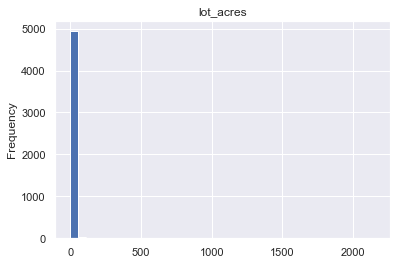

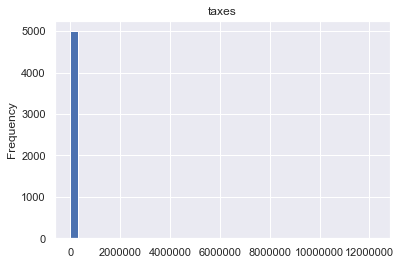

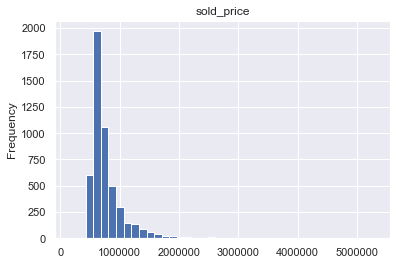

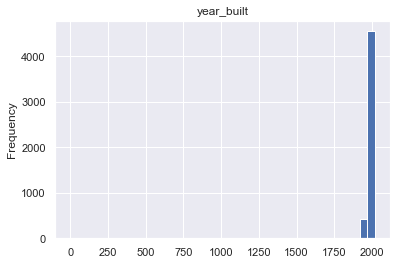

In [17]:
for var in ["lot_acres","taxes","sold_price", "year_built",]:
    distribution(data,var)

There are outliers that are skewing the distribution, let's focus on year_built, sold price and lots_acres

### Relationship between null values and sold_price

In [18]:
def nan_analysis(df, var):
    df = df.copy()
    df[var] = np.where(df[var].isnull(), 1, 0)
    df.groupby(var)['sold_price'].median().plot.bar(var, df['sold_price'], color = ["blue", "orange"])
    plt.ylabel("Median Sold Price")
    plt.title(var)
    plt.show()

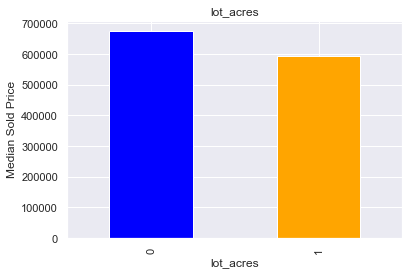

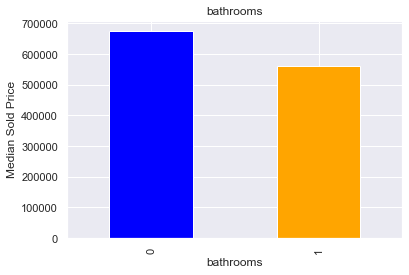

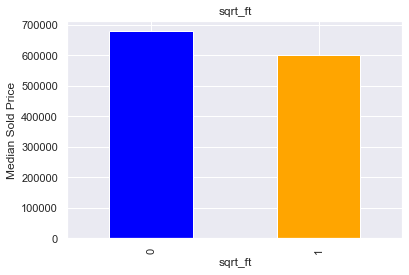

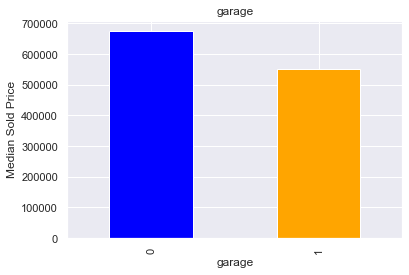

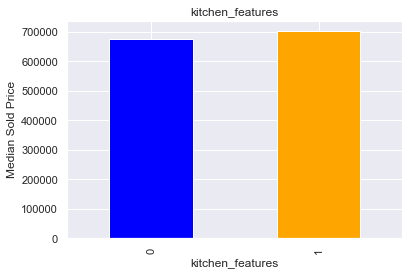

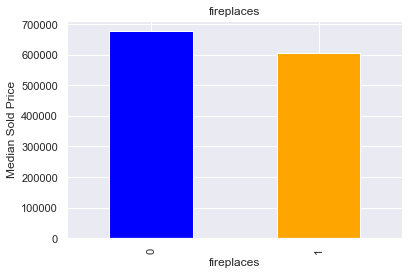

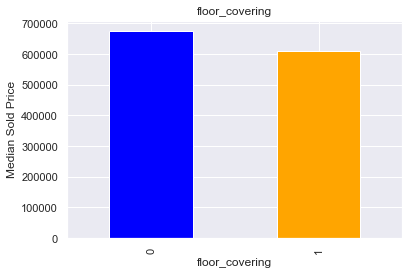

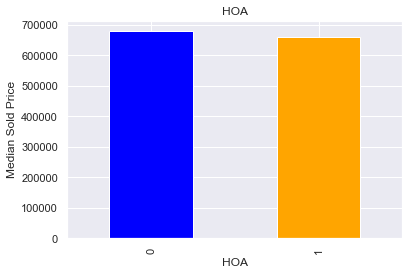

In [19]:
for var in missing:
    nan_analysis(data, var)

The median Soldprice in house where the information is missing differs from the data where information exist, there are some exceptions in HOA and Kitchen features.

### Year visualization after drops

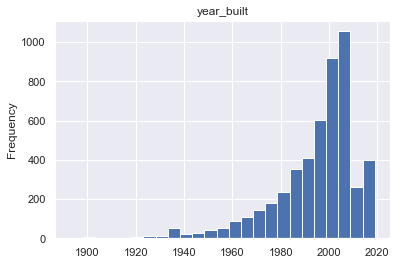

In [20]:
#Droping al year values that contains 0
data = data[data["year_built"] != 0].reset_index(drop = True)
data["year_built"].hist(bins = 25)
plt.ylabel("Frequency")
plt.title("year_built")
plt.ticklabel_format(style='plain', axis = "x")
plt.show()

Due deleting 0 values in year_built, we get a better distribution. We still have to remove outliers get more generalization

### Relationship between yearbuilt vs sold_price

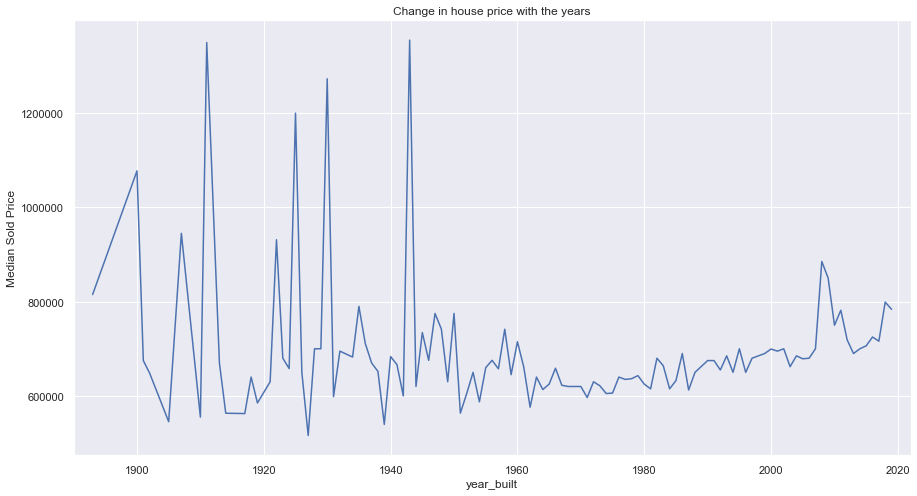

In [21]:
data.groupby("year_built")["sold_price"].median().plot(figsize = (15,8))
plt.ylabel("Median Sold Price")
plt.xlim(1890,2022)
plt.ticklabel_format(style='plain', axis = "y")
plt.title("Change in house price with the years")
plt.show()

#### We see that there are some outliers that don't follow the trend, it could be:
    - Big houses built in privileged zones with full acommodations
    - People who got very lucky selling their house
    - Low number of observations. Since we are using de soldprice median, if there's only one house built in that year it 
    will add its full value

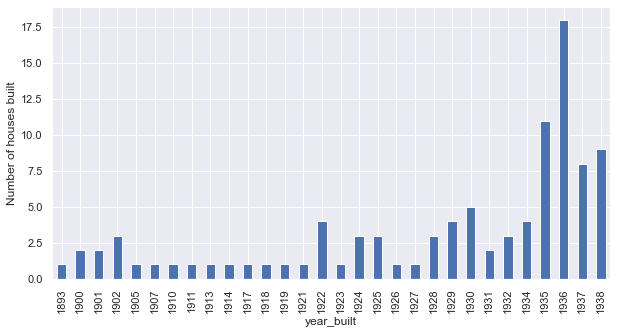

In [22]:
data.groupby("year_built")["sold_price"].count().head(30).plot.bar(figsize = (10,5))
plt.ylabel("Number of houses built")
plt.show()

We see that from 1893 to 1921 there are few houses built, that's the reason of capturing all the noise in the relationship time vs soldprice. So we have to remove the observations in that range

In [23]:
exp_houses_year = data.groupby("year_built")["sold_price"].median().sort_values(ascending = False)
exp_houses_year = exp_houses_year.loc[exp_houses_year > 900000]
exp_houses_year

year_built
1943   1355000.00
1911   1350000.00
1930   1273000.00
1925   1200000.00
1900   1077500.00
1907    945000.00
1922    931500.00
Name: sold_price, dtype: float64

### Relationship between zipcode vs sold_price

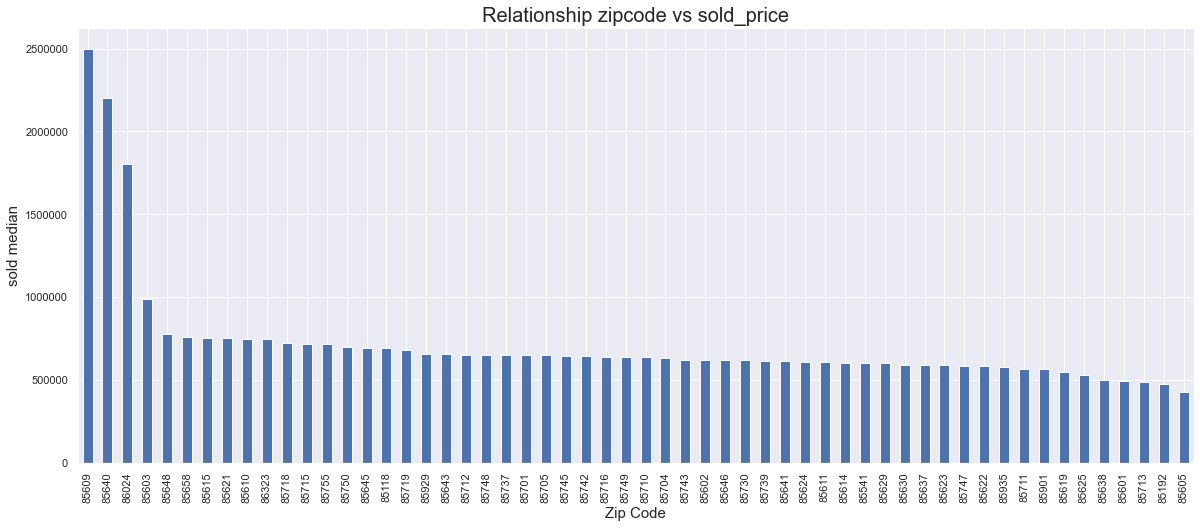

In [19]:
data.groupby("zipcode")["sold_price"].median().sort_values(ascending = False).plot.bar(figsize = (20,8))
plt.title("Relationship zipcode vs sold_price", fontsize = 20)
plt.ylabel("sold median", fontsize = 15)
plt.xlabel("Zip Code", fontsize = 15)
plt.ticklabel_format(style='plain', axis = "y")
#plt.xlim(0,50)
plt.show()

We notice that there are 3 high income zones which sold price median is above 1.8MM USD, the rest of the zones are below 1MM USD.

### Grouping number of houses per zipcode

Text(0, 0.5, 'House Percentage per zipcodes')

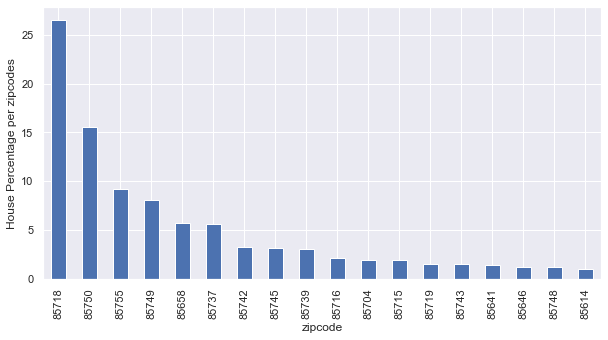

In [24]:
n_houses_zip = (data.groupby("zipcode")["sold_price"].count().sort_values(ascending = False)/len(data))*100
n_houses_zip.loc[n_houses_zip > .9].plot.bar(figsize = (10,5))
plt.ylabel("House Percentage per zipcodes")

There's one zip code that contain one quarter of the total houses observations

### Locating houses in the map

In [25]:
major = data.loc[data["zipcode"] == 85718]

In [26]:
px.scatter_mapbox(major[["longitude", "latitude"]],  lat = 'latitude', lon = 'longitude', 
                  center=dict(lon=-111, lat=32.37), zoom = 10, mapbox_style = "open-street-map")

Visualization of the 25% of houses built. They are grouped in a place called Catalina Foothills

### Most expensive houses

In [27]:
exp_houses = data.loc[data["sold_price"] > 2000000]
px.scatter_mapbox(exp_houses[["longitude", "latitude"]], lat = 'latitude', lon = 'longitude',
                  center=dict(lon=-111, lat=32.37), zoom = 10, mapbox_style = "open-street-map")

Looking at the map, there are expensive houses close to the mountains but also far from the city (Tucson)

In [28]:
exp_houses = data.loc[data["zipcode"] == 85609]
px.scatter_mapbox(exp_houses[["longitude", "latitude"]], lat = 'latitude', lon = 'longitude',
                  center=dict(lon=-111, lat=32.37), zoom = 10, mapbox_style = "open-street-map")

The most expensive zipcode only contains one observation, definitively not representative

### Cheapest houses

In [29]:
cheap_houses = data.loc[data["sold_price"] < 500000]
px.scatter_mapbox(cheap_houses[["longitude", "latitude"]], lat = 'latitude', lon = 'longitude',
                  center=dict(lon=-111, lat=32.37), zoom = 10, mapbox_style = "open-street-map")

The distribution of the cheapest houses is quite similar as the expensive ones

### Year built vs year sold

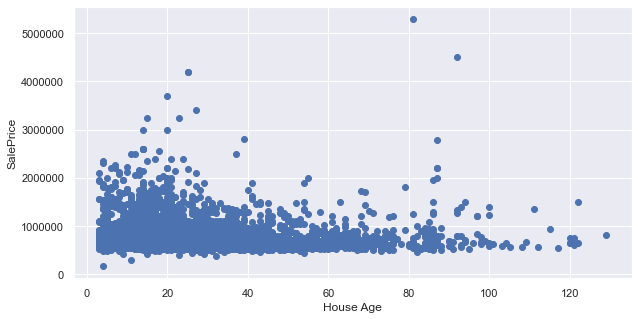

In [28]:
def analyse_year_vars(df, var, year_sold = 2022):
    df = df.copy()
    
    # capture difference between year variable and year
    # in which the house was sold
    df[var] = 2022 - df[var]
    
    plt.figure(figsize =  (10,5))
    plt.scatter(df[var], df['sold_price'])
    plt.ylabel('SalePrice')
    plt.xlabel("House Age")
    plt.ticklabel_format(style='plain', axis = "y")
    plt.show()
    
analyse_year_vars(data, date_cols)

We see that there is a tendency to a decrease in price, with older features. In other words, the longer the time between the house was built and sale date, the lower the sale Price. 

Which makes sense, cause this means that the house will have an older look, and potentially needs repairs.

### Filling nan

In [29]:
for var in missing:

    # calculate the mode using the train set
    mode_val = data[var].mode()[0]

    # replace missing values by the mode
    # (in train and test)
    data[var] = data[var].fillna(mode_val)

# check that we have no more missing values in the engineered variables
data[missing].isnull().sum()

lot_acres           0
bathrooms           0
sqrt_ft             0
garage              0
kitchen_features    0
fireplaces          0
floor_covering      0
HOA                 0
dtype: int64

In [30]:
data["HOA"] = data["HOA"].replace({"20,000":20000, "2,000":2000, "1,290": 1290, "1,769":1769,
                                   "8,333": 8333, "1,000":1000, "19,480":19480, '1,600':1600, 
                                   "1,010": 1010, "1,200":1200, "1,717": 1717, "1,100":1100,
                                  "1,270":1270, "5,900":5900})

In [31]:
data["HOA"] = data["HOA"].astype(float).astype(int)

In [32]:
cols = [var for var in data.columns if var != "MLS"]
num_cols = [var for var in cols if data[var].dtype != 'O' and var != 'year_built']
cat_cols = [var for var in cols if data[var].dtype == 'O']
date_cols = [var for var in cols if var not in num_cols + cat_cols]

discrete = [var for var in num_cols if len(data[var].unique()) < 22 and var not in date_cols+["MLS"]]
continuous = [var for var in num_cols if var not in discrete+date_cols+["MLS"]]

In [33]:
integers = ["MLS","sold_price","zipcode","year_built","bedrooms","fireplaces"]
decimals = ["bathrooms","sqrt_ft","garage","fireplaces"]

In [34]:
def castObjectVars(df,cols_int,cols_float):
    '''This function casts dtype objects to a better fit'''
    
    df = df.copy()
    for x in cols_int:
        df[x] = data[x].astype(int)
    
    for i in cols_float:
        df[i] = data[i].values.astype(float).tolist()
    return df

In [35]:
data = castObjectVars(data,integers,decimals)

In [66]:
def transform_analyse_continuous(df, var):
    df = df.copy()

    if any(data[var] <= 0):
        pass
    else:
        # log transform the variable
        df[var] = np.log(df[var])
        
        df['sold_price'] = np.log(df["sold_price"])
        
        # plot
        plt.scatter(df[var], df["sold_price"])
        plt.ylabel('SalePrice')
        plt.xlabel(var)
        plt.show()


for var in continuous:
    if var not in ['sold_price',"latitude", "longitude", "zipcode"]:
        transform_analyse_continuous(data, var)

In [37]:
from collections import Counter
kitchen = data["kitchen_features"]
kit_feats = [var.split(",") for var in kitchen.values.tolist()]
kit_feats = [[var.lower().strip() for var in kit_feats[i]] for i in range(len(kit_feats))]

for x in range(2):
    Counter(kit_feats[x])

In [38]:
kitchen=data['kitchen_features'].apply(lambda x: x.split(','))
unique={}
for row in kitchen:
    for item in row:
        if ':' in item:
            item=item.split(':')
            if item[0] in unique:
                unique[item[0]]+=1
            else:
                unique[item[0]]=1
            
        elif item in unique:
            unique[item]+=1
        else:
            unique[item]=1

In [39]:
kitc_keys = [var.strip() for var in unique.keys()]
kitc_values = [var for var in unique.values()]

In [40]:
dict(filter(lambda elem: elem[1] > 40, unique.items()))

{'Dishwasher': 4171,
 ' Freezer': 392,
 ' Refrigerator': 4236,
 ' Oven': 3996,
 ' Garbage Disposal': 4511,
 ' Double Sink': 1153,
 ' Pantry': 1458,
 ' Microwave': 3652,
 'Compactor': 431,
 ' Dishwasher': 714,
 ' Electric Range': 395,
 ' Island': 1249,
 ' Appliance Color': 1565,
 ' Countertops': 1480,
 ' Gas Range': 1302,
 ' Prep Sink': 302,
 'Desk': 289,
 ' Warming Drawer': 217,
 ' Lazy Susan': 332,
 ' Indoor Grill': 53,
 ' Wet Bar': 234,
 ' Water Purifier': 168,
 ' Reverse Osmosis': 220}

### Extracting kitchen features

In [41]:
""" For the kitchen_features feature, it is necessary to first separate the
characteristics into different columns. After that, we can observe which ones
each house contains, and then create a new column with the vectorized
representations of them (not one-hot encoders). """

# Join every single characteristic into one list
feature = data["kitchen_features"]
kitchen_chars = []
kitchen_vectors = []

for i in feature:
    description = i.lower().split(",")
    kitchen_chars += description

# Create a vector with all the unique values
labels = []

for i in kitchen_chars:
    if ':' in i:
        aux = i.split(':')[0]
        labels.append(aux) #Just keep the general feature
    #print(f"Saving {aux}")
    elif i[0] == ' ':
        aux = i[1:]
        labels.append(aux)
    else:
        labels.append(i)
    #print(f"Saving {i}")

labels = np.unique(labels) 

#These labels should be given to the programming team as additional data
labels = ['appliance_color','countertops','microwave','electric_oven','convection_oven','gas_oven','compactor','desk',
          'dishwasher','sink','freezer','garbage_disposal','pantry','indoor_grill','lazy_susan','refrigerator',
          'water_purifier','warming_drawer','wet_bar','wine_cooler']

for i in feature:
    encoder = np.zeros(20)
    description = i.lower().split(",")

    for j in description:
        if ':' in j:
            j = j.split(':')[0]
    
        j = j.replace(' ','_')
    
    for k in range(len(labels)):
        if labels[k] in j:
            encoder[k] = 1
        else:
            if j == 'black' or j == 'stainless':
                encoder[0] = 1
            if j == 'butch_block' or j == 'island' or j == 'quartzite':
                encoder[1] = 1
            if 'electric' in j:
                encoder[3] = 1
            if j == 'oven' or 'convection' in j or j == '#_of_ovens':
                encoder[4] = 1
            if 'gas' in j:
                encoder[5] = 1
            if 'osmosis' in j:
                encoder[16] = 1
  
    kitchen_vectors.append(encoder)

# Create the columns with the presence of each feature
appliance = []
countertop = []
microwave = []
electric = []
convection = []
gas = []
compactor = []
desk = []
dishwasher = []
sink = []
freezer = []
garbage = []
pantry = []
grill = []
lazy = []
refrigerator = []
purifier = []
warming = []
wet = []
wine = []

for i in kitchen_vectors:
    appliance.append(i[0])
    countertop.append(i[1])
    microwave.append(i[2])
    electric.append(i[3])
    convection.append(i[4])
    gas.append(i[5])
    compactor.append(i[6])
    desk.append(i[7])
    dishwasher.append(i[8])
    sink.append(i[9])
    freezer.append(i[10])
    garbage.append(i[11])
    pantry.append(i[12])
    grill.append(i[13])
    lazy.append(i[14])
    refrigerator.append(i[15])
    purifier.append(i[16])
    warming.append(i[17])
    wet.append(i[18])
    wine.append(i[19])

data['appliance'] = appliance
data['countertop'] = countertop
data['microwave'] = microwave
data['electric'] = electric
data['convection'] = convection
data['gas'] = gas
data['compactor'] = compactor
data['desk'] = desk
data['dishwasher'] = dishwasher
data['sink'] = sink
data['freezer'] = freezer
data['garbage'] = garbage
data['pantry'] = pantry
data['grill'] = grill
data['lazy'] = lazy
data['refrigerator'] = refrigerator
data['purifier'] = purifier
data['warming'] = warming
data['wet'] = wet
data['wine'] = wine

data['appliance'] = data['appliance'].astype(int)
data['countertop'] = data['countertop'].astype(int)
data['microwave'] = data['microwave'].astype(int)
data['electric'] = data['electric'].astype(int)
data['convection'] = data['convection'].astype(int)
data['gas'] = data['gas'].astype(int)
data['compactor'] = data['compactor'].astype(int)
data['desk'] = data['desk'].astype(int)
data['dishwasher'] = data['dishwasher'].astype(int)
data['sink'] = data['sink'].astype(int)
data['freezer'] = data['freezer'].astype(int)
data['garbage'] = data['garbage'].astype(int)
data['pantry'] = data['pantry'].astype(int)
data['grill'] = data['grill'].astype(int)
data['lazy'] = data['lazy'].astype(int)
data['refrigerator'] = data['refrigerator'].astype(int)
data['purifier'] = data['purifier'].astype(int)
data['warming'] = data['warming'].astype(int)
data['wet'] = data['wet'].astype(int)
data['wine'] = data['wine'].astype(int)

### Extracting floor features

In [42]:
feature = data["floor_covering"]
floor_chars = []
floor_vectors = []

for i in feature:
    description = i.lower().split(",")
    floor_chars += description

# Create a vector with all the unique values
labels = []

for i in floor_chars:
    if ':' in i:
        aux = i.split(':')[1] #Save the first keyword of the description after the ':'
        labels.append(aux) #Just keep the general feature
    #print(f"Saving {aux}")
    else:
        labels.append(i)
    #print(f"Saving {i}")

labels = np.unique(labels)

#These labels should be given to the programming team as additional data
labels = ['mexican','porcelain','stone','acrylic','wood','brick','carpet','ceramic',
          'concrete','vinyl','marble','other']

for i in feature:
    encoder = np.zeros(12)
    description = i.lower().split(",")

    for j in description:
        if ':' in j:
            j = j.split(':')[1]
    
    for k in range(len(labels)):
        if labels[k] == j or labels[k] in j:
            encoder[k] = 1
        else:
            if 'talavera' in j:
                encoder[0] = 1
            if 'italian' in j or 'porcelain wood' in j or 'porclain' in j:
                encoder[1] = 1
            if 'cantera' in j or 'canterra' in j:
                encoder[2] = 1
            if 'bamboo' in j or 'brazilian' in j:
                encoder[3] = 1
  
    floor_vectors.append(encoder)

# Create the columns with the presence of each feature
mexican = []
porcelain = []
stone = []
acrylic = []
wood = []
brick = []
carpet = []
ceramic = []
concrete = []
vinyl = []
marble = []
other = []

for i in floor_vectors:
    mexican.append(i[0])
    porcelain.append(i[1])
    stone.append(i[2])
    acrylic.append(i[3])
    wood.append(i[4])
    brick.append(i[5])
    carpet.append(i[6])
    ceramic.append(i[7])
    concrete.append(i[8])
    vinyl.append(i[9])
    marble.append(i[10])
    other.append(i[11])

data['mexican'] = mexican
data['porcelain'] = porcelain
data['stone'] = stone
data['acrylic'] = acrylic
data['wood'] = wood
data['brick'] = brick
data['carpet'] = carpet
data['ceramic'] = ceramic
data['concrete'] = concrete
data['vinyl'] = vinyl
data['marble'] = marble
data['other'] = other

data['mexican'] = data['mexican'].astype(int)
data['porcelain'] = data['porcelain'].astype(int)
data['stone'] = data['stone'].astype(int)
data['acrylic'] = data['acrylic'].astype(int)
data['wood'] = data['wood'].astype(int)
data['brick'] = data['brick'].astype(int)
data['carpet'] = data['carpet'].astype(int)
data['ceramic'] = data['ceramic'].astype(int)
data['concrete'] = data['concrete'].astype(int)
data['vinyl'] = data['vinyl'].astype(int)
data['marble'] = data['marble'].astype(int)
data['other'] = data['other'].astype(int)

### Outliers

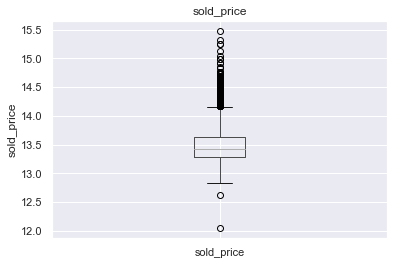

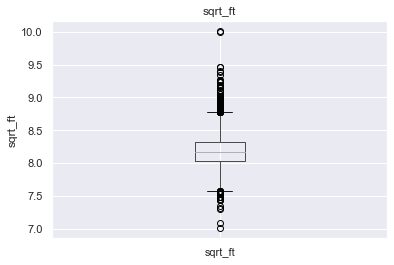

In [43]:
def find_outliers(df, var):
    df = df.copy()

    # log does not take negative values, 
    if any(data[var] <= 0):
        pass
    else:
        df[var] = np.log(df[var])
        df.boxplot(column=var)
        plt.title(var)
        plt.ylabel(var)
        plt.show()


for var in ["sold_price","lot_acres","taxes","sqrt_ft"]:
    find_outliers(data, var)

### Discrete variables

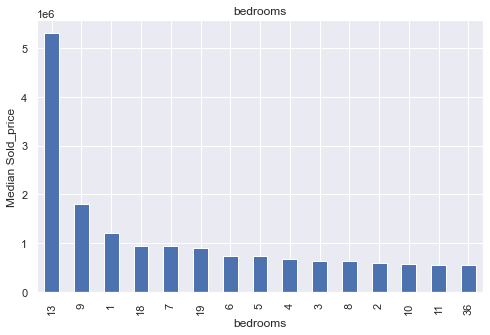

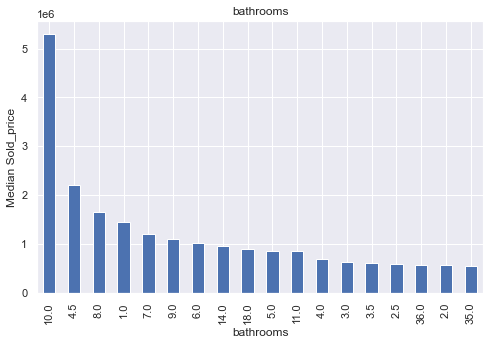

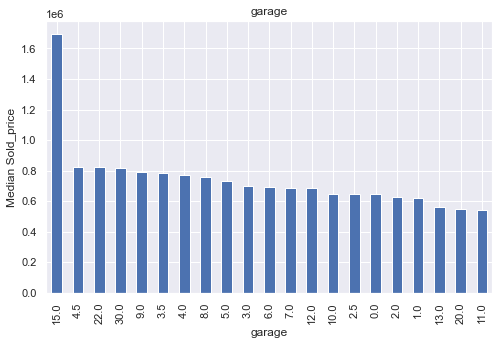

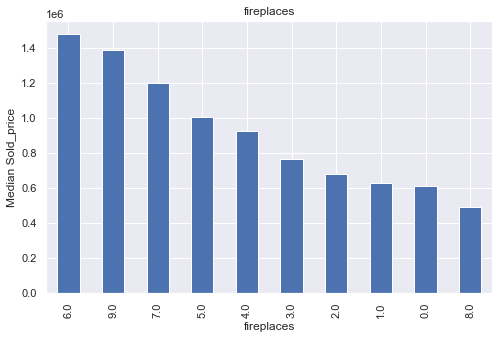

In [44]:
def analyse_discrete(df, var):
    
    df = df.copy()
    df.groupby(var)['sold_price'].median().sort_values(ascending = False).plot.bar(figsize = (8,5))
    plt.title(var)
    plt.ylabel('Median Sold_price')
    #plt.ticklabel_format(style='plain', axis = "x")
    plt.show()
    
for var in ['bedrooms','bathrooms', 'garage','fireplaces']:
    analyse_discrete(data, var)

It seems there is no a strong correlation among these variables versus the sold price median. Except fireplaces

In [45]:
def analyse_material_feats(df, var):
    
    df = df.copy()
    df.groupby(var)['sold_price'].median().plot.bar(color = ["blue", "orange"])
    plt.title(var)
    plt.ylabel('Median Sold_price')
    #plt.ticklabel_format(style='plain', axis = "x")
    plt.show()

In [46]:
material_feats =['appliance', 'countertop', 'microwave',
       'electric', 'convection', 'gas', 'compactor', 'desk', 'dishwasher',
       'sink', 'freezer', 'garbage', 'pantry', 'grill', 'lazy',
       'refrigerator', 'purifier', 'warming', 'wet', 'wine', 'mexican',
       'porcelain', 'stone', 'acrylic', 'wood', 'brick', 'carpet',
       'ceramic', 'concrete', 'vinyl', 'marble', 'other']

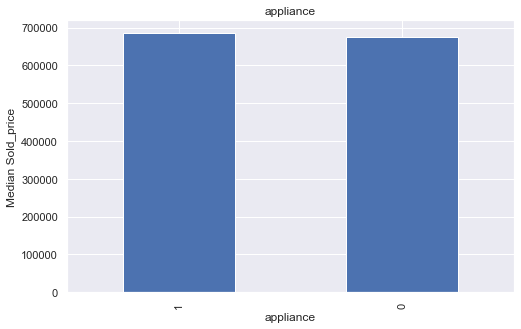

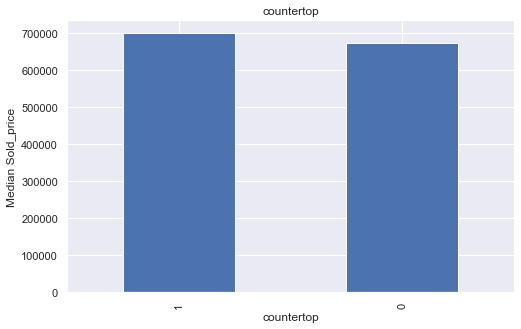

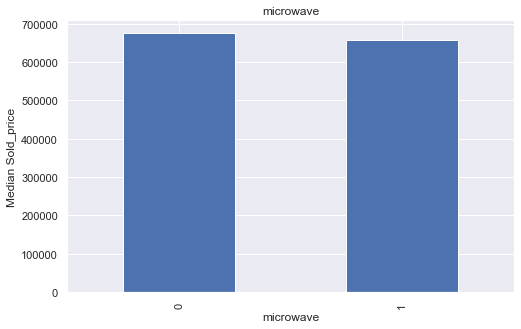

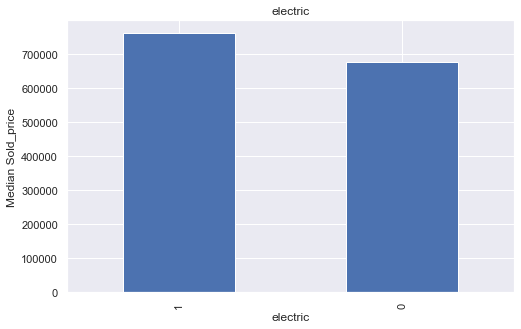

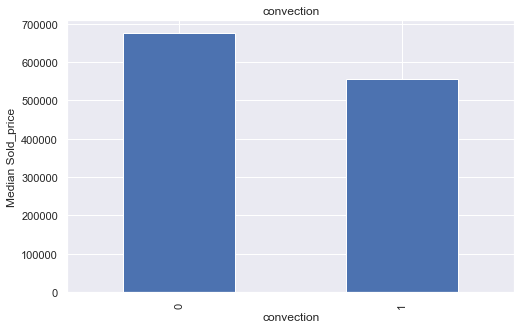

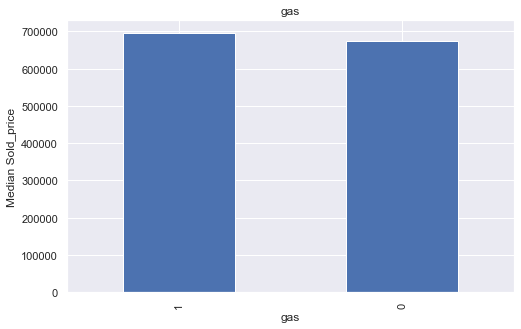

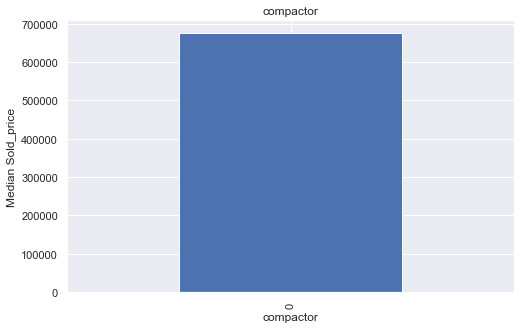

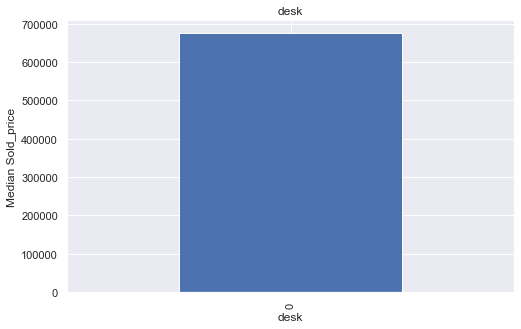

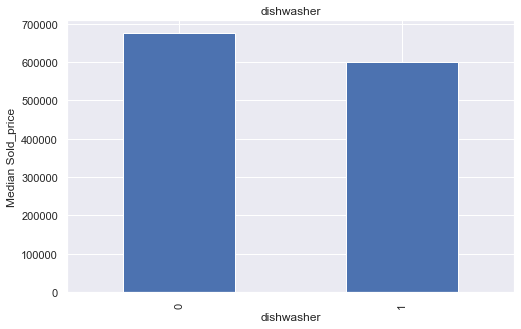

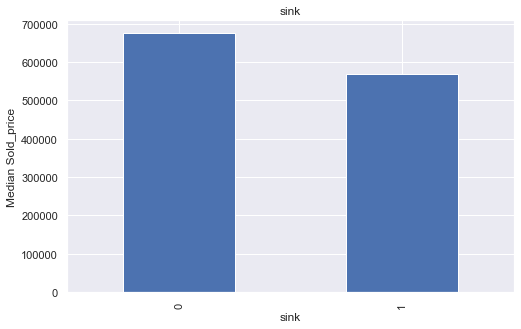

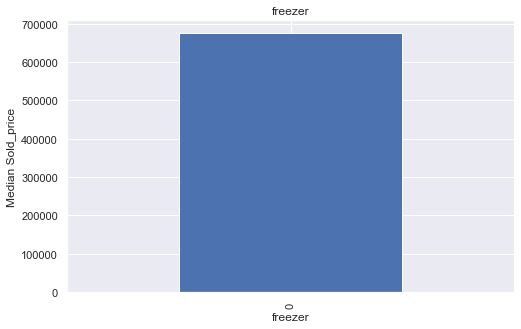

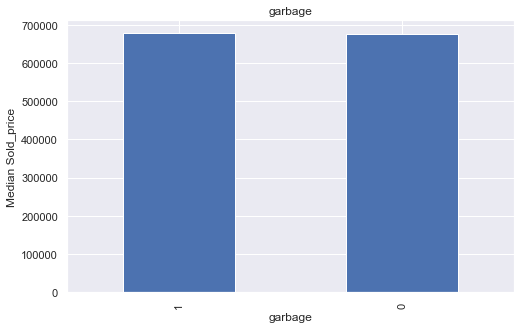

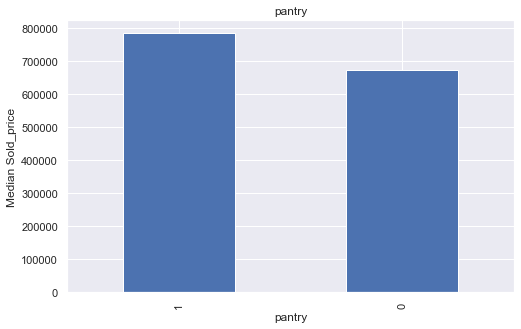

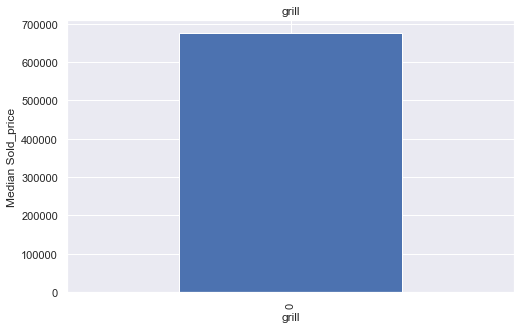

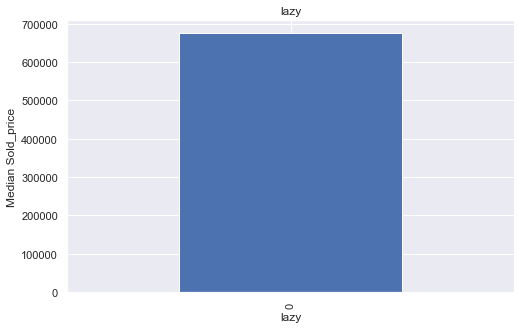

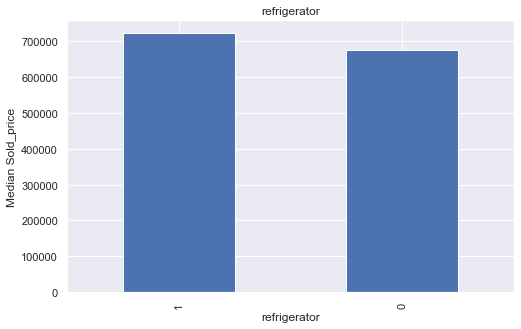

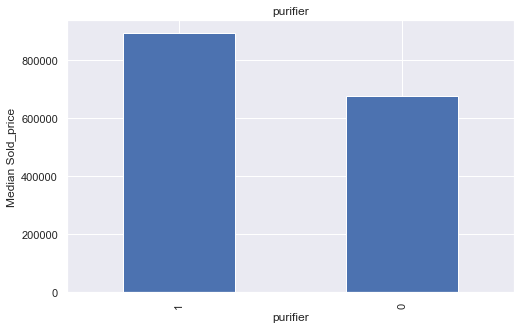

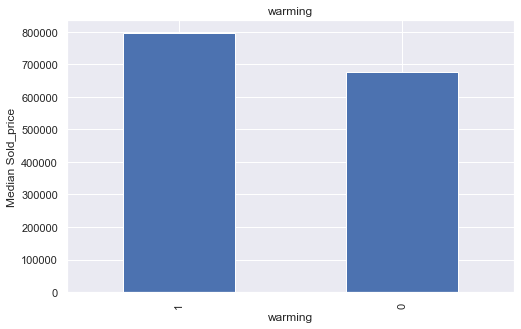

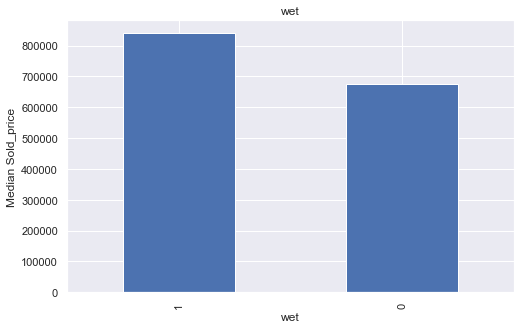

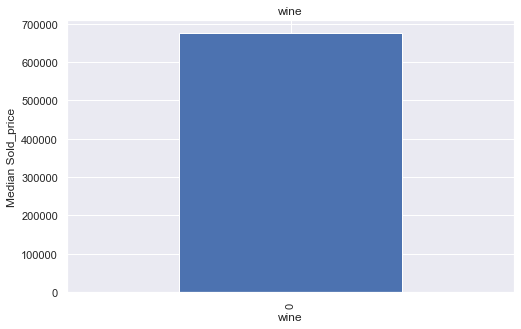

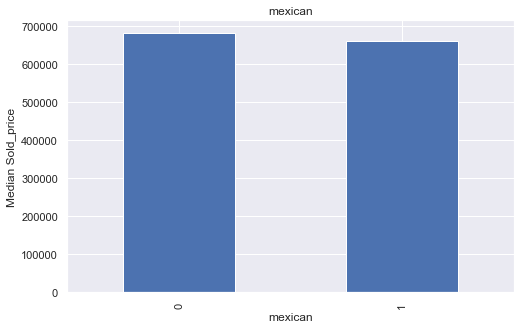

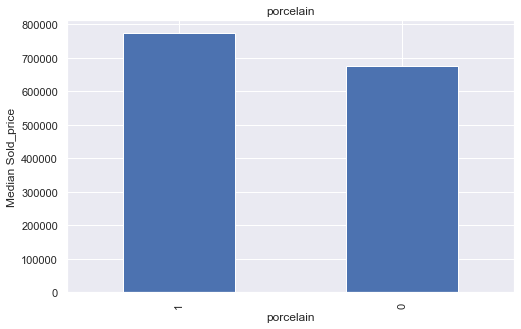

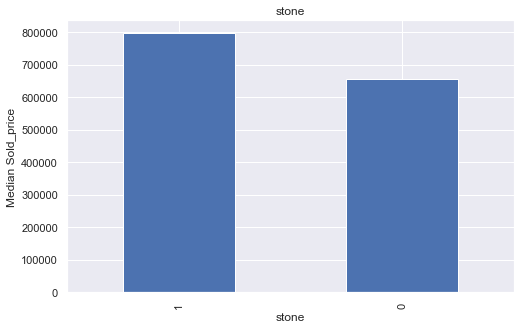

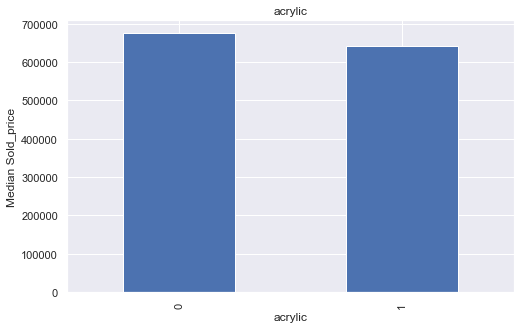

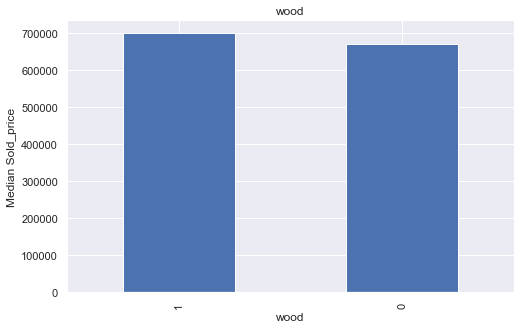

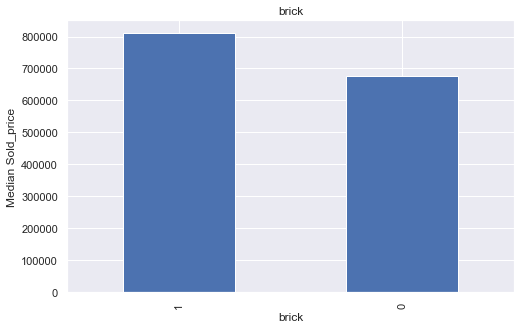

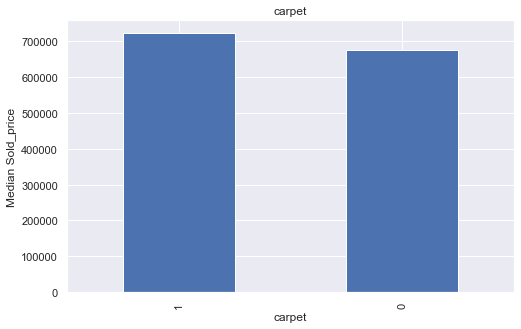

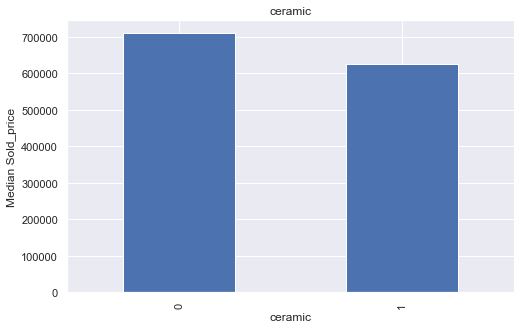

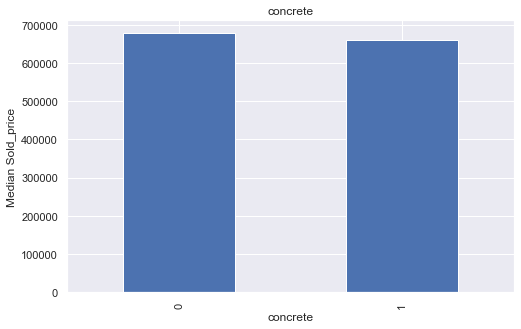

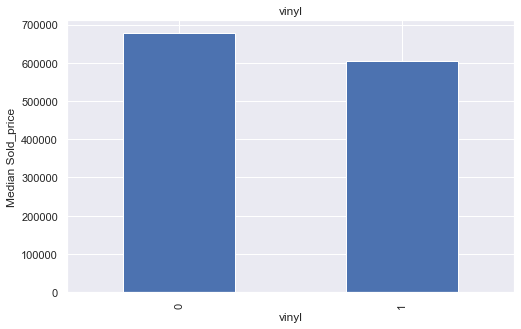

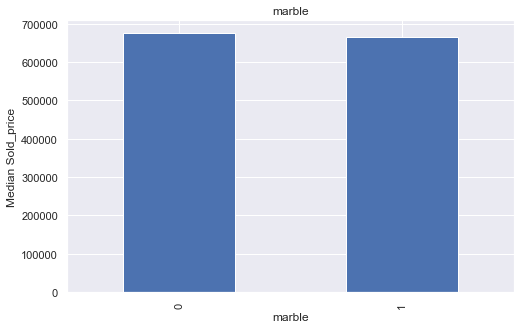

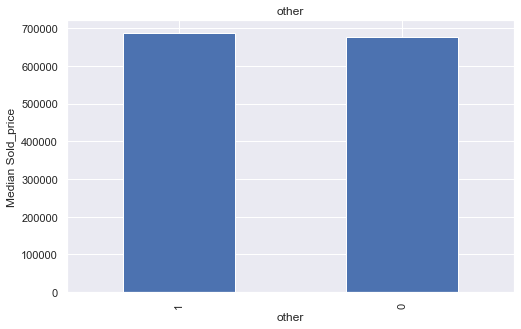

In [47]:
for var in material_feats:
    analyse_discrete(data, var)

When these kitchen feats are present in the house, the price elevates: electric, pantry, refrigerator, purifier, warming,wet
On the other hand containing these features lower the price: convection, dishwasher, sink

When the floor is made of: porcelain, stone, brick, carpet the price elevates
Materials that lower the price: acrylic, ceramic, vinyl,

In [145]:
data.corr()

MLS  sold_price   zipcode  longitude  latitude  lot_acres  \
MLS           1.000000    0.031112  0.323645   0.118503  0.442647  -0.078716   
sold_price    0.031112    1.000000 -0.037364  -0.038180  0.038495   0.331065   
zipcode       0.323645   -0.037364  1.000000   0.048736  0.456031  -0.125185   
longitude     0.118503   -0.038180  0.048736   1.000000 -0.252830   0.127967   
latitude      0.442647    0.038495  0.456031  -0.252830  1.000000  -0.198045   
lot_acres    -0.078716    0.331065 -0.125185   0.127967 -0.198045   1.000000   
taxes         0.003309    0.023463 -0.001315  -0.000985  0.000780  -0.000535   
year_built   -0.000433    0.097020  0.009996  -0.108342  0.174695  -0.067384   
bedrooms     -0.012289    0.108998  0.053716   0.056469 -0.087735   0.066135   
bathrooms    -0.053694    0.321180 -0.047151   0.013594 -0.073530   0.051522   
sqrt_ft      -0.037924    0.520953 -0.000625   0.057184 -0.108071   0.103549   
garage       -0.008896    0.102675  0.079632  -0.040817  0.059050  -0.051335   
fireplaces   -0.022880    0.384852 -0.005807   0.049617 -0.073711   0.085051   
HOA          -0.007145    0.161186 -0.017970  -0.018136  0.035894  -0.009857   
appliance     0.025113    0.004482 -0.005780  -0.016811  0.014879  -0.008779   
countertop    0.004455    0.020718 -0.025853  -0.003753 -0.030676  -0.006988   
microwave    -0.100423   -0.000823 -0.034854  -0.000654 -0.066118  -0.001288   
electric      0.005307    0.022825 -0.010145   0.013292  0.008340   0.000861   
convection    0.004120   -0.015669  0.014652   0.017356  0.004260  -0.000379   
gas          -0.039228    0.016570 -0.010713  -0.002662 -0.021153   0.006348   
compactor          NaN         NaN       NaN        NaN       NaN        NaN   
desk               NaN         NaN       NaN        NaN       NaN        NaN   
dishwasher    0.010573   -0.021842 -0.004084  -0.009396  0.004169   0.014118   
sink         -0.073324   -0.012865 -0.013721   0.004637 -0.034770   0.008700   
freezer            NaN         NaN       NaN        NaN       NaN        NaN   
garbage       0.010249    0.022894 -0.036275  -0.030686  0.020535   0.088363   
pantry        0.008379   -0.005058 -0.014655   0.027677 -0.003884   0.059926   
grill              NaN         NaN       NaN        NaN       NaN        NaN   
lazy               NaN         NaN       NaN        NaN       NaN        NaN   
refrigerator  0.016542    0.046977 -0.031675  -0.018639 -0.035228   0.056705   
purifier     -0.024622    0.020481  0.004747  -0.002386  0.002634  -0.002489   
warming       0.005236    0.014466  0.003608   0.007973  0.002320  -0.001818   
wet           0.009040    0.028025 -0.002970  -0.014820  0.017146  -0.002616   
wine               NaN         NaN       NaN        NaN       NaN        NaN   
mexican      -0.039641   -0.050367  0.005714   0.045062 -0.091031   0.010705   
porcelain     0.012742    0.017374 -0.001963  -0.012686  0.007353  -0.007241   
stone         0.042461    0.170754  0.038726  -0.032520  0.072408  -0.028394   
acrylic       0.007026   -0.006234 -0.007496   0.073733 -0.034520   0.002829   
wood          0.026054    0.105275 -0.019448   0.024863 -0.014542   0.014584   
brick        -0.006113    0.028224  0.011210  -0.012942  0.033801   0.002207   
carpet        0.009018   -0.009975 -0.012775  -0.013211 -0.005857  -0.000959   
ceramic      -0.012707   -0.229068  0.012863  -0.016089  0.065191  -0.027177   
concrete      0.022180   -0.009393 -0.025621  -0.024741 -0.031860  -0.006220   
vinyl        -0.024027   -0.021144 -0.017147   0.004907 -0.041969   0.010805   
marble       -0.075186    0.023656 -0.026527  -0.003967 -0.029760  -0.002363   
other        -0.030927    0.034087 -0.001088   0.027963 -0.038874   0.045640   

                 taxes  year_built  bedrooms  bathrooms  ...     stone  \
MLS           0.003309   -0.000433 -0.012289  -0.053694  ...  0.042461   
sold_price    0.023463    0.097020  0.108998   0.321180  ...  0.170754   
zipcode      -0.001315    0.009996  

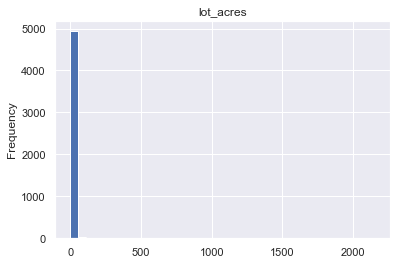

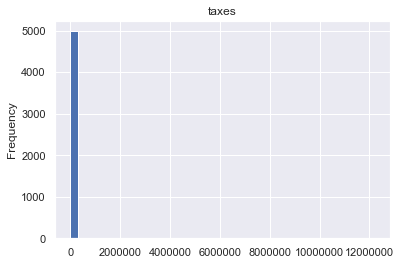

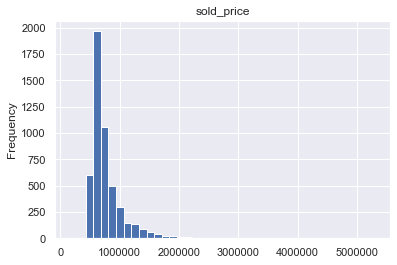

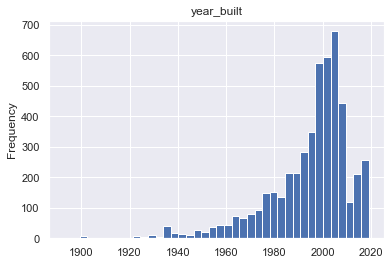

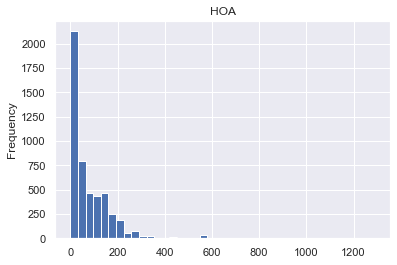

In [63]:
data = data.loc[data["HOA"] < 1500]
for var in ["lot_acres","taxes","sold_price", "year_built", "HOA"]:
    distribution(data,var)

In [62]:
data.loc[data["HOA"] > 1500][feats+["HOA"]]

sold_price  zipcode  lot_acres  year_built  bedrooms  bathrooms  garage  \
14       3000000    85739       0.00        2008         3        3.0     0.0   
26       2600000    85739       0.15        2008         3        3.0     0.0   
52       2150000    85739       0.00        2008         2        3.0     0.0   
255      1494392    85755       1.85        2017         3        4.0     3.0   
425      1225000    85750       1.45        2001         5        6.0     3.0   
485      1050000    85718       1.20        2002         4        4.0     3.0   
1638      784500    85718       0.79        1994         3        4.0     3.0   
2855      606500    85629       0.17        2014         5        5.0     3.0   
2933      655000    85614       1.50        2001         3        4.0     3.0   

      fireplaces    HOA  
14           3.0  20000  
26           3.0   1717  
52           2.0  20000  
255          1.0  19480  
425          4.0   2000  
485          3.0   1600  
1638         2.0   1769  
2855         1.0   5900  
2933         2.0   8333

In [67]:
data

MLS  sold_price  zipcode   longitude   latitude  lot_acres  \
0     21530491     5300000    85637 -110.378200  31.356362    2154.00   
1     21529082     4200000    85646 -111.045371  31.594213    1707.00   
2      3054672     4200000    85646 -111.040707  31.594844    1707.00   
3     21919321     4500000    85646 -111.035925  31.645878     636.67   
4     21306357     3411450    85750 -110.813768  32.285162       3.21   
...        ...         ...      ...         ...        ...        ...   
4990  21810382      495000    85641 -110.661829  31.907917       4.98   
4991  21908591      550000    85750 -110.858556  32.316373       1.42   
4992  21832452      475000    85192 -110.755428  32.964708      12.06   
4993  21900515      550000    85745 -111.055528  32.296871       1.01   
4994   4111490      450000    85621 -110.913054  31.385259       4.16   

         taxes  year_built  bedrooms  bathrooms  ...  stone  acrylic wood  \
0      5272.00        1941        13       10.0  ...      0        0    1   
1     10422.36        1997         2        2.0  ...      0        0    0   
2     10482.00        1997         2        3.0  ...      0        0    0   
3      8418.58        1930         7        5.0  ...      0        0    1   
4     15393.00        1995         4        6.0  ...      0        0    0   
...        ...         ...       ...        ...  ...    ...      ...  ...   
4990   2017.00        2005         5        3.0  ...      0        0    0   
4991   4822.01        1990         4        3.0  ...      0        0    0   
4992   1000.00        1969         3        2.0  ...      0        0    0   
4993   5822.93        2009         4        4.0  ...      0        0    0   
4994   2814.48        1988         4        4.0  ...      0        0    0   

      brick carpet  ceramic  concrete  vinyl  marble  other  
0         0      0        0         0      0       0      0  
1         0      0        0         0      0       0      1  
2         0      0        0         0      0       0      0  
3         0      0        0         0      0       0      0  
4         0      0        0         1      0       0      0  
...     ...    ...      ...       ...    ...     ...    ...  
4990      0      0        1         0      0       0      0  
4991      0      0        1         0      0       0      0  
4992      0      0        1         0      0       0      0  
4993      0      0        1         0      0       0      0  
4994      0      0        0         0      0       0      0  

[4986 rows x 48 columns]